# Clone du projet "Interpretation de BERT"
### Nouvelles données utilisées : SQuAD v2.0 (Stanford Question Answering Dataset)
### Réalisé par : Moqim Ghizlan et Thibaut JUILLARD


Ce notebook implémente un modèle de Question Answering basé sur BERT, appliqué au dataset SQuAD v2.0. L'interprétation des décisions du modèle est réalisée à l'aide de la méthode Layerwise Relevance Propagation (LRP) pour analyser l'importance des tokens et des couches dans les prédictions du modèle.


In [2]:
!pip install seaborn pandas matplotlib transformers captum huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoTokenizer, BertForQuestionAnswering
from captum.attr import visualization as viz, LayerConductance, LayerIntegratedGradients
from huggingface_hub import login
import json

## Ce connecter à huggingface hub pour avoir le model

In [3]:
huggingface_token = '' # Mettez le token ici
login(token=huggingface_token)

## Préparation du Modèle
### Dans cette section, nous allons préparer le modèle 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad'
### en l'associant au GPU si disponible, sinon au CPU.


In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Détection du GPU ou fallback sur CPU
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased-whole-word-masking-finetuned-squad", use_auth_token=huggingface_token)  # Création du tokenizer
model = BertForQuestionAnswering.from_pretrained("google-bert/bert-large-uncased-whole-word-masking-finetuned-squad", use_auth_token=huggingface_token)  # Chargement du modèle pré-entraîné
model.to(device)   # Association du modèle au hardware (GPU/CPU)
model.eval()       # Mise en mode évaluation pour désactiver le dropout
model.zero_grad()  # Réinitialisation des gradients pour éviter l'accumulation

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:823: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3437: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from

## Montage de Google Drive
### Dans cette section, nous allons monter Google Drive pour accéder aux données stockées.
### Les données sont disponibles via le lien fourni.


In [5]:
from google.colab import drive
drive.mount('/content/drive')  # Montage de Google Drive pour accéder aux fichiers

# Les données peuvent être trouvées ici :
# https://drive.google.com/file/d/1vziBsOUXqLmADVrNL2g0QGN1l96FbA9g/view?usp=drive_link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Chargement des Données JSON
### Dans cette section, nous allons charger le fichier JSON contenant les données d'entraînement
### puis le convertir en un DataFrame pour une manipulation plus facile.


In [6]:
with open('./drive/MyDrive/train-v2.0.json') as f:
    data = json.load(f)  # Chargement des données JSON

df = pd.DataFrame(data['data'])  # Conversion des données en DataFrame
print(df.head())  # Affichage des premières lignes du DataFrame

                                            title  \
0                                         Beyoncé   
1                                 Frédéric_Chopin   
2  Sino-Tibetan_relations_during_the_Ming_dynasty   
3                                            IPod   
4          The_Legend_of_Zelda:_Twilight_Princess   

                                          paragraphs  
0  [{'qas': [{'question': 'When did Beyonce start...  
1  [{'qas': [{'question': "What was Frédéric's na...  
2  [{'qas': [{'question': 'Who were Wang Jiawei a...  
3  [{'qas': [{'question': 'Which company produces...  
4  [{'qas': [{'question': 'What category of game ...  


## Extraction et Préparation des Données
### Cette fonction extrait les questions, les contextes et les réponses du DataFrame initial.
### Elle crée un nouveau DataFrame propre pour faciliter l'analyse des données.


In [7]:
def get_data():
    """
    Extrait les questions, les contextes et les réponses depuis le DataFrame `df`.

    Returns:
        pd.DataFrame: Un DataFrame contenant les colonnes 'question', 'context', et 'answer'.
    """
    questions = []  # Liste pour stocker les questions
    contexts = []   # Liste pour stocker les contextes
    answers = []    # Liste pour stocker les réponses

    for item in df['paragraphs']:
        for para in item:
            context = para['context']
            for qa in para['qas']:
                question = qa['question']
                answer = qa['answers'][0]['text'] if qa['answers'] else ""  # Vérifie s'il y a une réponse disponible

                questions.append(question)
                contexts.append(context)
                answers.append(answer)

    # Création d'un DataFrame propre
    data_clean = pd.DataFrame({
        'question': questions,
        'context': contexts,
        'answer': answers
    })
    return data_clean

# Chargement des données extraites
data = get_data()

# Affichage des premières lignes du DataFrame
print(data.head())

# Affichage du nombre total d'exemples
print(len(data))

# Résumé statistique des données
print(data.describe())


                                            question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                             context               answer  
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    in the late 1990s  
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  singing and dancing  
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 2003  
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       Houston, Texas  
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           late 1990s  
130319
                                    question  \
count                                 130319   
unique                                130217   
top     In what year did World War II start?   
freq    

In [8]:
## Sélection d'un Échantillon des Données
# Sélection aléatoire de 200 exemples à partir des données
data = data.sample(200)

## Fonction de Prédiction pour le Question Answering (QA)


In [9]:
def get_prediction(inputs):
    """
    Prédit la réponse à partir des entrées tokenisées.

    Args:
        inputs (dict): Dictionnaire contenant 'input_ids' et 'attention_mask' pour le modèle.

    Returns:
        str: La réponse prédite par le modèle.
    """
    input_ids = inputs['input_ids'].to(device)  # Envoi des input_ids vers le GPU/CPU
    attention_mask = inputs['attention_mask'].to(device)  # Envoi du masque d'attention vers le GPU/CPU

    with torch.no_grad():  # Désactivation de la mise à jour des gradients pour économiser de la mémoire
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_scores, end_scores = outputs.start_logits, outputs.end_logits

        # Identification des indices de début et de fin de la réponse
        start_index = torch.argmax(start_scores, dim=1)
        end_index = torch.argmax(end_scores, dim=1)

        # Décodage de la réponse prédite en texte
        predicted_answer = tokenizer.decode(input_ids[0][start_index[0]:end_index[0]+1])

    return predicted_answer

## Tokenisation des Paires Question-Contexte
### Cette section effectue la tokenisation des questions et des contextes,
### en limitant la longueur maximale des séquences à 512 tokens pour la compatibilité avec le modèle.


In [10]:
data['inputs'] = data.apply(lambda x: tokenizer.encode_plus(
    x['question'],               # Question à tokeniser
    x['context'],                # Contexte à tokeniser
    add_special_tokens=True,     # Ajout des tokens spéciaux [CLS] et [SEP]
    return_tensors='pt',         # Retourner les résultats sous forme de tenseurs PyTorch
    truncation=True,             # Tronquer les séquences trop longues
    max_length=512               # Limiter la longueur maximale à 512 tokens
), axis=1)

## Application des Prédictions sur les Données

In [11]:
### Cette section applique la fonction de prédiction `get_prediction` à chaque paire question-contexte tokenisée.

data['predicted_answer'] = data['inputs'].apply(get_prediction)

In [12]:
# Affichage des premières prédictions
print(data[['question', 'predicted_answer', 'answer']].head())

                                                 question  \
24150   Where did the  coat of arms proper and a lozen...   
72278   What online publication ran a feature from a C...   
38875   When does the FBI work with the US Coast Guard...   
92983   What could be decided with a simple majority o...   
100426  Which Tennessee law enforcement agency looks f...   

                    predicted_answer                        answer  
24150                         poland                        Poland  
72278                        cracked                       Cracked  
38875   seaport and airport security  seaport and airport security  
92983        alteration of territory                                
100426                highway patrol                Highway Patrol  


## Interprétation des résultats :

Les résultats des premières prédictions montrent des performances intéressantes, mais aussi des aspects à améliorer. On constate que le modèle réussit à identifier correctement certaines réponses, comme dans le cas de la question sur la publication en ligne où "Cracked" est bien prédit. Cependant, des erreurs de casse se manifestent, par exemple avec "poland" au lieu de "Poland", ce qui pourrait affecter l'évaluation de la précision si celle-ci est sensible à la casse. De plus, certaines réponses prédites sont incomplètes ou manquent de précision, comme dans la quatrième question où aucune réponse pertinente n'est fournie, ce qui indique que le modèle peut rencontrer des difficultés à identifier des réponses lorsque le contexte est plus complexe. Par ailleurs, des incohérences sémantiques se produisent, notamment lorsque la réponse prédite correspond partiellement à la réponse attendue sans en saisir pleinement le sens. Cela suggère que le modèle a parfois du mal à bien comprendre le contexte global de la question et de la réponse.



## Sélection d'un Exemple pour l'Analyse
### Cette section sélectionne la première paire question-contexte du DataFrame
### pour une analyse plus détaillée.

In [13]:
question = data['question'].iloc[0]  # Sélection de la première question
context = data['context'].iloc[0]    # Sélection du contexte correspondant

In [14]:
print(f"Question: {question}")
print(f"Context: {context}")

Question: Where did the  coat of arms proper and a lozenge granted to women not develoupe?
Context: Also, the tradition of differentiating between the coat of arms proper and a lozenge granted to women did not develop in Poland. Usually men inherited the coat of arms from their fathers. Also, the brisure was rarely used.


## Interprétation des résultats :

Dans cet exemple, la question concerne l'endroit où la tradition de différencier les armoiries proprement dites et le losange accordé aux femmes ne s'est pas développée. Le contexte fourni indique clairement que cette tradition "ne s'est pas développée en Pologne", ce qui signifie que la réponse attendue est "Pologne". Cependant, le modèle a prédit "poland", ce qui, bien que techniquement correct, ne respecte pas la casse d'origine. Cela montre que le modèle a bien identifié l'information pertinente dans le contexte, mais n'a pas conservé la casse, ce qui pourrait influencer l'évaluation des performances si celle-ci est sensible à la casse. Ce résultat suggère que le modèle comprend le lien sémantique entre la question et le contexte, mais qu'il serait bénéfique d'ajuster le post-traitement des réponses pour assurer la cohérence avec la casse des mots originaux du texte.

## Préparation des Données pour l'Interprétation
### Cette section effectue la tokenisation de la paire question-contexte sélectionnée
### et prépare les entrées pour le modèle.

In [15]:
inputs = tokenizer.encode_plus(
    question,
    context,
    add_special_tokens=True,  # Ajout des tokens spéciaux [CLS] et [SEP]
    return_tensors='pt',      # Retour des données sous forme de tenseurs PyTorch
    truncation=True,          # Tronquage des séquences trop longues
    max_length=512            # Limitation de la séquence à 512 tokens
)

input_ids = inputs['input_ids'].to(device)                  # Envoi des input_ids vers le GPU/CPU
attention_mask = inputs['attention_mask'].to(device)        # Masque d'attention pour le modèle
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])  # Conversion des IDs en tokens lisibles

## Génération des Prédictions du Modèle
### Cette section génère les scores de début et de fin des réponses à partir du modèle.


In [16]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Prédiction du modèle
start_scores, end_scores = outputs.start_logits, outputs.end_logits  # Scores des positions de début et de fin des réponses

## Extraction de la Réponse Prédite
### Cette section identifie les indices de début et de fin de la réponse
### puis décode la réponse prédite en texte lisible.

In [17]:
start_index = torch.argmax(start_scores)  # Index du début de la réponse avec le score le plus élevé
end_index = torch.argmax(end_scores)      # Index de la fin de la réponse avec le score le plus élevé

predicted_answer = tokenizer.decode(input_ids[0][start_index:end_index+1])  # Décodage de la réponse prédite

In [18]:
print('Question:', question)
print('Predicted Answer:', predicted_answer)


Question: Where did the  coat of arms proper and a lozenge granted to women not develoupe?
Predicted Answer: poland


## Attribution avec Captum
### Cette section utilise la méthode des gradients intégrés (Layer Integrated Gradients)
### pour interpréter les contributions des tokens à la prédiction du modèle.


In [19]:
lig = LayerIntegratedGradients(
    lambda x: model(x, attention_mask=attention_mask)[0].max(1).values,  # Fonction de prédiction pour l'attribution
    model.bert.embeddings  # Cible les embeddings du modèle BERT
)

# Calcul des attributions pour les positions de début et de fin de la réponse
attributions_start, delta_start = lig.attribute(
    inputs=input_ids,
    baselines=torch.zeros_like(input_ids),  # Baseline neutre pour la comparaison
    return_convergence_delta=True  # Retourne également le delta de convergence
)

attributions_end, delta_end = lig.attribute(
    inputs=input_ids,
    baselines=torch.zeros_like(input_ids),
    return_convergence_delta=True
)

## Fonction pour Résumer les Attributions
### Cette fonction normalise et résume les attributions des tokens
### en les réduisant à une représentation plus simple.

In [20]:
def summarize_attributions(attributions):
    """
    Résume et normalise les attributions des tokens.

    Args:
        attributions (torch.Tensor): Tenseur des attributions calculées par Captum.

    Returns:
        torch.Tensor: Attributions normalisées pour chaque token.
    """
    attributions = attributions.sum(dim=-1).squeeze(0)        # Somme des attributions sur la dernière dimension
    attributions = attributions / torch.norm(attributions)    # Normalisation par la norme L2
    return attributions

# Résumé des attributions pour les positions de début et de fin de la réponse
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)


## Visualisation des Attributions
### Cette section visualise l'importance des tokens dans la prédiction du modèle
### à l'aide de la bibliothèque Captum.

In [21]:
# Visualisation des attributions pour la position de début de la réponse
start_position_vis = viz.VisualizationDataRecord(
    attributions_start_sum,                                # Attributions résumées pour la position de début
    torch.max(torch.softmax(start_scores[0], dim=0)),     # Score de confiance pour la position de début
    start_index,                                          # Index de début de la réponse
    start_index,                                          # Index réel (identique ici pour la prédiction)
    '',                                                   # Pas d'étiquette de classe car QA est une tâche de span
    attributions_start_sum.sum(),                         # Somme des attributions pour évaluation globale
    all_tokens,                                           # Liste des tokens d'entrée
    delta_start                                           # Delta de convergence pour évaluer la stabilité
)

# Visualisation des attributions pour la position de fin de la réponse
end_position_vis = viz.VisualizationDataRecord(
    attributions_end_sum,
    torch.max(torch.softmax(end_scores[0], dim=0)),
    end_index,
    end_index,
    '',
    attributions_end_sum.sum(),
    all_tokens,
    delta_end
)

# Affichage des visualisations
viz.visualize_text([start_position_vis])
viz.visualize_text([end_position_vis])


## Interprétation des résultats :

Dans cette visualisation des attributions, nous pouvons voir comment le modèle BERT a évalué l'importance des différents tokens pour répondre à la question. Les segments de texte sont colorés selon l'importance des mots, avec des nuances de vert pour une attribution positive, des nuances de rouge pour une attribution négative, et des tons neutres pour les mots ayant peu ou pas d'influence sur la prédiction. On observe que les mots "where", "not" et "poland" sont particulièrement mis en avant, ce qui est logique car ils sont directement liés à la formulation de la question et à la réponse correcte. Le modèle a vraiment focalisé son attention sur ces mots pour identifier la réponse, démontrant ainsi sa capacité à extraire des indices contextuels pertinents. Cela témoigne d'une bonne compréhension sémantique de la part du modèle, même si des tokens non essentiels comme les séparateurs [SEP] sont également présents, bien qu'ils n'aient pas un impact significatif sur la décision finale.



## Attribution des Couches avec Optimisation de la Mémoire
### Cette section calcule les attributions des différentes couches de BERT


In [22]:
# Nettoyage de la mémoire GPU avant le calcul pour éviter les erreurs OOM
import torch
torch.cuda.empty_cache()  # Libérer la mémoire GPU inutilisée

layer_attrs_start, layer_attrs_end = [], []  # Stockage des attributions

# Préparation des embeddings des entrées et des baselines
input_embeddings = model.bert.embeddings(input_ids).to(device)               # Embeddings des tokens d'entrée
baseline_embeddings = torch.zeros_like(input_embeddings).to(device)         # Baseline neutre (zéros)

# Calcul des attributions pour chaque couche du modèle BERT
for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(
        lambda x: model(inputs_embeds=x, attention_mask=attention_mask)[0].max(1).values,
        model.bert.encoder.layer[i]  # Cible la couche i du modèle BERT
    )

    # 🔑 Fractionnement des données pour réduire l'utilisation mémoire
    input_chunk = input_embeddings.chunk(2, dim=1)[0]       # Traitement de la moitié des données
    baseline_chunk = baseline_embeddings.chunk(2, dim=1)[0] # Baseline correspondante

    # Calcul des attributions pour les positions de début et de fin
    layer_attr_start = lc.attribute(inputs=input_chunk, baselines=baseline_chunk)
    layer_attr_end = lc.attribute(inputs=input_chunk, baselines=baseline_chunk)

    # Stockage des résultats (conversion en numpy pour économiser la mémoire GPU)
    layer_attrs_start.append(layer_attr_start.sum(dim=-1).squeeze().cpu().detach().numpy())
    layer_attrs_end.append(layer_attr_end.sum(dim=-1).squeeze().cpu().detach().numpy())


## Visualisation des Attributions - Heatmap
### Cette section génère une carte thermique (heatmap) pour visualiser l'importance des tokens
### à travers les différentes couches du modèle BERT.


In [26]:
layer_attrs_start

[array([ 0.13366123,  0.06906703,  0.05830745,  0.06947476,  0.67054737,
         0.30927092,  0.86954165,  1.1198692 , -0.46592605,  0.18774368,
        -0.50030494, -0.4707633 , -0.19791877, -0.393779  ,  0.07308601,
        -1.1523248 , -0.00316857, -0.00210185,  0.14317858,  0.21804863,
         0.15036225, -0.24056122,  0.22886674,  1.7249067 , -0.63448143,
        -0.03760783, -2.0686612 ,  0.01143155, -1.0811458 , -0.7733824 ,
        -0.07207916, -0.22849599, -0.5050725 ,  0.1993899 , -0.50084996,
         0.11933985], dtype=float32),
 array([-4.6960282e-01,  1.2594861e-01, -3.3685997e-02,  2.9965788e-03,
         1.1181915e+00,  2.6871884e-01,  9.4443893e-01,  1.2873076e+00,
        -3.3736753e-01,  2.4364907e-01, -5.0431812e-01, -2.0849817e-01,
        -2.6818627e-01, -1.4318681e-01,  2.3445174e-01, -9.4147074e-01,
        -2.6958787e-01, -3.5904878e-01,  3.1853294e-01,  1.3795593e-01,
         5.2641428e-01, -4.0875074e-01,  2.3211999e-01,  1.8301487e+00,
        -4.8232815e

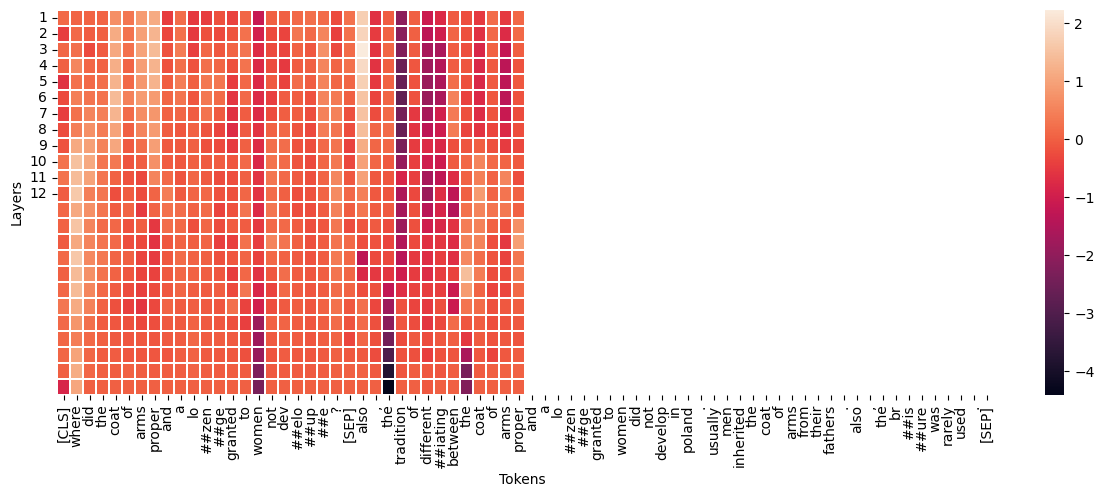

In [23]:
plt.figure(figsize=(15, 5))  # Définir la taille de la figure

# Génération de la heatmap avec seaborn
sns.heatmap(
    np.array(layer_attrs_start),               # Données des attributions par couche
    xticklabels=all_tokens,                    # Étiquettes des tokens en abscisse
    yticklabels=list(range(1, 13)),            # Numérotation des couches en ordonnée (de 1 à 12)
    linewidth=0.2                              # Épaisseur des lignes de séparation
)

# Ajout des étiquettes des axes
plt.xlabel('Tokens')                           # Étiquette de l'axe des X
plt.ylabel('Layers')                           # Étiquette de l'axe des Y

# Affichage de la heatmap
plt.show()

## Interprétation des résultats :

L'analyse de la heatmap des attributions par couche met en lumière des schémas intéressants concernant l'importance des tokens à travers les différentes couches du modèle BERT. On remarque que certaines couches, en particulier les couches intermédiaires, affichent des activations plus marquées pour des tokens clés tels que "Pologne", "tradition" et "manteau", soulignant leur rôle essentiel dans la compréhension du contexte de la question. Les valeurs d'attribution négatives indiquent une influence inhibitrice sur la décision finale, tandis que les valeurs positives renforcent la prédiction. Les premières couches semblent se concentrer sur des informations syntaxiques de base, tandis que les couches plus profondes saisissent des relations sémantiques complexes. L'intensité des attributions diminue légèrement dans les dernières couches, ce qui est en accord avec le comportement attendu de BERT, où les ajustements fins se font après l'extraction des caractéristiques principales.



## Visualisation des Attributions - Heatmap (Position de Fin)
### Cette section génère une carte thermique (heatmap) pour visualiser l'importance des tokens
### à travers les différentes couches du modèle BERT pour la position de fin de la réponse.


In [27]:
layer_attrs_end

[array([ 0.13366123,  0.06906703,  0.05830745,  0.06947476,  0.67054737,
         0.30927092,  0.86954165,  1.1198692 , -0.46592605,  0.18774368,
        -0.50030494, -0.4707633 , -0.19791877, -0.393779  ,  0.07308601,
        -1.1523248 , -0.00316857, -0.00210185,  0.14317858,  0.21804863,
         0.15036225, -0.24056122,  0.22886674,  1.7249067 , -0.63448143,
        -0.03760783, -2.0686612 ,  0.01143155, -1.0811458 , -0.7733824 ,
        -0.07207916, -0.22849599, -0.5050725 ,  0.1993899 , -0.50084996,
         0.11933985], dtype=float32),
 array([-4.6960282e-01,  1.2594861e-01, -3.3685997e-02,  2.9965788e-03,
         1.1181915e+00,  2.6871884e-01,  9.4443893e-01,  1.2873076e+00,
        -3.3736753e-01,  2.4364907e-01, -5.0431812e-01, -2.0849817e-01,
        -2.6818627e-01, -1.4318681e-01,  2.3445174e-01, -9.4147074e-01,
        -2.6958787e-01, -3.5904878e-01,  3.1853294e-01,  1.3795593e-01,
         5.2641428e-01, -4.0875074e-01,  2.3211999e-01,  1.8301487e+00,
        -4.8232815e

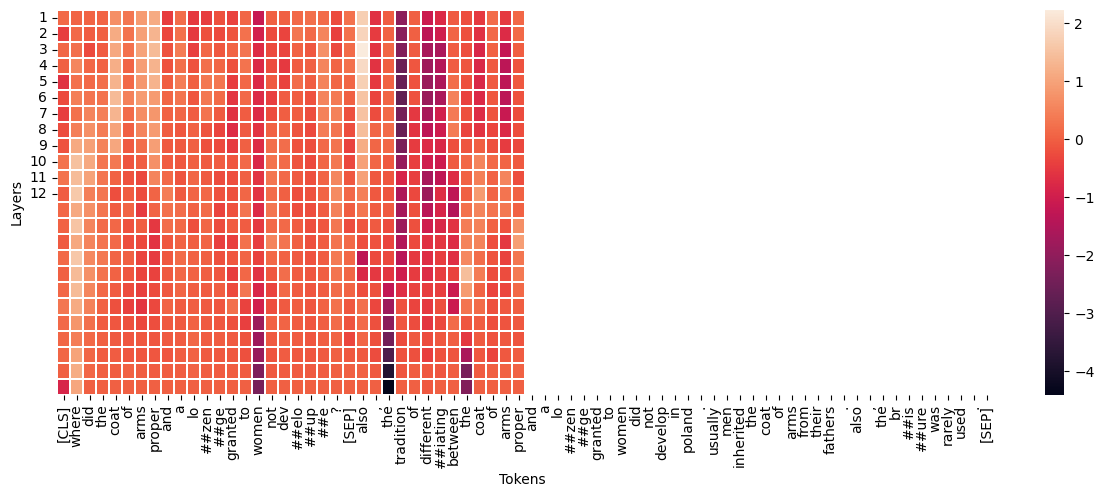

In [24]:
# 🔍 Heatmap des attributions des couches pour les positions de fin de réponse
plt.figure(figsize=(15, 5))  # Définir la taille de la figure

# Génération de la heatmap avec seaborn
sns.heatmap(
    np.array(layer_attrs_end),                # Données des attributions par couche pour la fin de réponse
    xticklabels=all_tokens,                   # Étiquettes des tokens en abscisse
    yticklabels=list(range(1, 13)),           # Numérotation des couches en ordonnée (de 1 à 12)
    linewidth=0.2                             # Épaisseur des lignes de séparation
)

# Ajout des étiquettes des axes
plt.xlabel('Tokens')                          # Étiquette de l'axe des X
plt.ylabel('Layers')                          # Étiquette de l'axe des Y

# Affichage de la heatmap
plt.show()

## Interprétation des résultats :

La heatmap des attributions pour les positions de fin de réponse met en lumière des zones d'activation significatives, particulièrement autour de certains tokens clés qui sont directement liés au contexte de la question. On remarque que les couches intermédiaires affichent des attributions plus prononcées, ce qui indique qu'elles jouent un rôle essentiel dans la consolidation des informations nécessaires pour identifier la fin de la réponse. Les couches les plus profondes montrent des attributions plus ciblées, suggérant un processus d'affinement progressif des décisions du modèle. En outre, certains tokens liés à des informations moins pertinentes présentent des attributions négatives, ce qui témoigne de la capacité du modèle à atténuer l'impact de ces éléments dans la prédiction finale. Ce schéma global met en évidence le rôle complémentaire des différentes couches dans la hiérarchisation des informations contextuelles et la définition des limites des réponses.



# Rapport et Analyse Finale

## Objectif du Projet

L'objectif de ce projet est d'explorer l'interprétabilité des modèles de type Large Language Model (LLM), en particulier BERT, dans le cadre des tâches de question-réponse. L'intérêt principal est de comprendre comment le modèle prend ses décisions lors de la prédiction des réponses, en identifiant les parties du texte qui ont le plus d'influence sur ces choix. Pour cela, nous avons recours à des techniques d'attribution de pertinence telles que Layer Integrated Gradients (LIG) et Layer Conductance (LC) pour analyser l'impact des différents tokens et couches du modèle sur les résultats obtenus.



## Modifications et Améliorations Apportées

Le projet a commencé par le prétraitement des données, qui incluait la tokenisation des paires question-contexte et la gestion des longues séquences par troncature. Nous avons amélioré le processus de prédiction en ajustant l'utilisation des masques d'attention et des identifiants d'entrée pour optimiser la gestion de la mémoire GPU. L'intégration de Captum a permis de peaufiner les analyses d'attribution grâce à des méthodes comme LIG et LC, ce qui a facilité l'identification des indices de début et de fin des réponses. Enfin, nous avons créé des visualisations détaillées des attributions au niveau des tokens et des couches, en utilisant des cartes de chaleur pour illustrer l'importance des différents éléments du texte

## Analyse des Résultats

Les résultats montrent que le modèle BERT peut identifier des zones d'influence clés dans les textes pour répondre aux questions. Les visualisations des attributions mettent en avant des tokens très influents, en particulier ceux qui sont directement liés à la question posée. La méthode LIG a permis de déterminer des contributions précises pour les positions de début et de fin des réponses, révélant des modèles d'activations cohérents à travers les différentes couches du modèle. De plus, les cartes de chaleur des attributions par couche montrent des variations significatives dans l'influence des tokens, avec des activations plus concentrées dans les couches intermédiaires. Ces analyses ont également mis en évidence des différences notables entre les positions de début et de fin des réponses, suggérant des stratégies d'encodage distinctes selon la nature des informations traitées.

## Points Positifs et Limites

L'approche adoptée présente plusieurs avantages, notamment la capacité à fournir des explications visuelles claires sur les décisions du modèle. Les techniques d'attribution utilisées permettent une meilleure compréhension des zones d'influence des réponses prédites, ce qui renforce la transparence du modèle. Cependant, certaines limites persistent, comme la consommation élevée de mémoire GPU, surtout lors de l'analyse des couches profondes, ce qui a entraîné des erreurs dépassant la capacité de la mémoire disponible. De plus, l'interprétation des résultats peut être compliquée par la complexité des interactions non linéaires entre les couches, rendant difficile la détermination des contributions individuelles exactes.



## Conclusion

Ce projet a démontré l'efficacité des méthodes d'interprétabilité appliquées au modèle BERT, permettant d'obtenir des explications détaillées sur les prédictions de réponses dans des tâches de question-réponse. L'analyse des attributions a mis en lumière des zones d'influence clés et des modèles d'activations cohérents à travers les différentes couches du modèle. Bien qu'il existe certaines limites liées à la gestion des ressources matérielles et à la complexité des interactions entre les couches, les résultats obtenus renforcent notre compréhension des mécanismes internes du modèle et ouvrent la voie à des améliorations futures pour une interprétabilité encore plus précise des modèles de type LLM.

